In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from src.data_processing.processors.TrainingProcessor import TrainingProcessor
from src.utilities.pandas_helpers import filter_columns_by_search, flatten_dataframe

In [2]:
%load_ext autoreload 
%autoreload 2 

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## load preprocessed data

In [4]:
data = pd.read_parquet("/Users/mds8301/iterm_data_storage/full_dataset.parquet.gzip")

## agg data down to max and min for each day

In [5]:
def calculate_max_min_signal(df):
    
    events = filter_columns_by_search(data, 'event')
    actions = filter_columns_by_search(data, 'action')
    mouse = filter_columns_by_search(data, 'mouse')
    sensors = filter_columns_by_search(data, 'sensor')
    return (
        df
        .groupby(by = mouse+events+actions+sensors+['day', 'trial_count'], as_index = False).agg({"signal": ["max", "min"]})
        .pipe(flatten_dataframe)
        .rename(columns = lambda c: c.strip("_"))
        .drop(columns ='index')
    )

max_min = calculate_max_min_signal(data)

### query for dopamine
#### distribution of action vs peaks

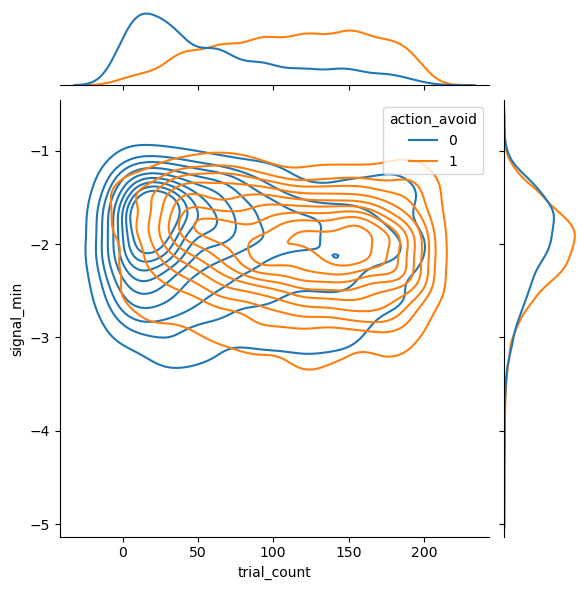

In [6]:
da = max_min.query("sensor_DA == 1")
sns.jointplot(
    data=da,
    x="trial_count", y="signal_min", hue="action_avoid",
    kind="kde"
)

# process data for training

In [6]:
classifer_processor = (TrainingProcessor(max_min)
                       .drop_colinear_columns('action_escape')
                       .query_sensor_and_sort_trials_by_subject(sensor = 'DA')
                       .split_train_val_test_by_subject(target = 'action_avoid')
                       .save_subjects_by_category(path = "/Users/mds8301/iterm_data_storage")
)
num_features = classifer_processor.train_x.columns.shape[0]
num_features

22

In [7]:
tf.keras.backend.clear_session()

# Base classifcation model 

In [165]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = (classifer_processor.train_x.shape[1],)),
    tf.keras.layers.Normalization(),
    # tf.keras.layers.Dense(10, activation='relu'),
    # tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc-roc')]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
base_model.compile(optimizer=opt,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=metrics)
base_model.fit(classifer_processor.train_x, classifer_processor.train_y,
          epochs=300 , batch_size=100, 
          validation_data=(classifer_processor.val_x, classifer_processor.val_y))

Epoch 1/300
42/42 [==============================] - 3s 61ms/step - loss: 6.5847 - accuracy: 0.4641 - precision: 0.5111 - recall: 0.2622 - auc-roc: 0.4040 - val_loss: 3.0446 - val_accuracy: 0.4656 - val_precision: 0.1176 - val_recall: 0.0040 - val_auc-roc: 0.2535
Epoch 2/300
42/42 [==============================] - 1s 18ms/step - loss: 6.2390 - accuracy: 0.4710 - precision: 0.5222 - recall: 0.2846 - auc-roc: 0.4097 - val_loss: 2.4968 - val_accuracy: 0.4646 - val_precision: 0.1111 - val_recall: 0.0040 - val_auc-roc: 0.2431
Epoch 3/300
42/42 [==============================] - 1s 16ms/step - loss: 5.8545 - accuracy: 0.4736 - precision: 0.5248 - recall: 0.3075 - auc-roc: 0.4216 - val_loss: 1.9843 - val_accuracy: 0.4646 - val_precision: 0.1111 - val_recall: 0.0040 - val_auc-roc: 0.2341
Epoch 4/300
42/42 [==============================] - 1s 14ms/step - loss: 5.4243 - accuracy: 0.4782 - precision: 0.5304 - recall: 0.3260 - auc-roc: 0.4348 - val_loss: 1.5534 - val_accuracy: 0.4625 - val_preci

In [153]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 22)                45        
 on)                                                             
                                                                 
 dense (Dense)               (None, 10)                230       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 286 (1.12 KB)
Trainable params: 241 (964.00 Byte)
Non-trainable params: 45 (184.00 Byte)
_________________________________________________________________


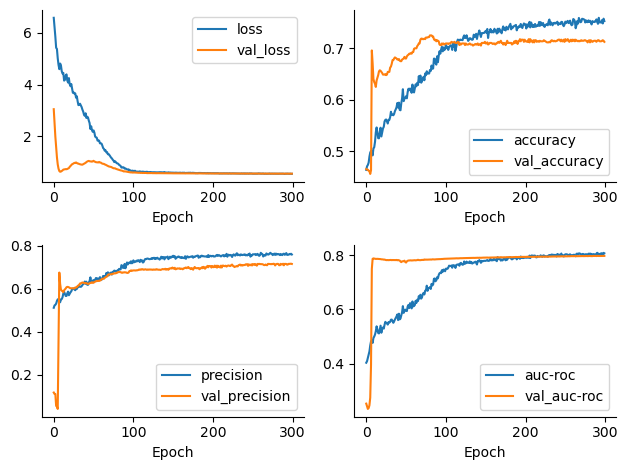

In [166]:
fig, ax = plt.subplots(2,2)
    
def plot_metrics(*metrics, model, title, ax):
    for metric in metrics:
        ax.plot(model.history.history[f'{metric}'], label=f'{metric}')
        ax.set_xlabel('Epoch')
        ax.legend() 
        sns.despine()

plot_metrics('loss', 'val_loss', model = base_model, title = 'Loss', ax = ax[0,0])
plot_metrics('accuracy', 'val_accuracy', model = base_model, title = 'Accuracy', ax = ax[0,1])
plot_metrics('precision', 'val_precision', model = base_model, title = 'Precision', ax = ax[1,0])
plot_metrics('auc-roc', 'val_auc-roc', model = base_model, title = 'Recall', ax = ax[1,1])
plt.tight_layout()

### although training is noisy, this model is the best accuracy for val and testing data. 

In [167]:
evalulation = base_model.evaluate(classifer_processor.test_x, classifer_processor.test_y)
for name, value in zip(base_model.metrics_names, evalulation):
    print(f'{name}: {value}')

40/40 [==============================] - 1s 20ms/step - loss: 0.5809 - accuracy: 0.7027 - precision: 0.8362 - recall: 0.6939 - auc-roc: 0.7635
loss: 0.5809425711631775
accuracy: 0.7027027010917664
precision: 0.8361823558807373
recall: 0.6938534379005432
auc-roc: 0.7634772062301636


### Distribution of true and predicted avoids
* model appears to increaes in accross across days (trial counts)

40/40 [==============================] - 0s 3ms/step


<Axes: xlabel='avoid', ylabel='day'>

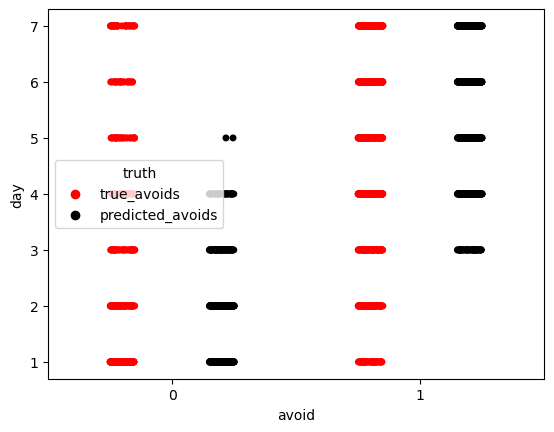

In [129]:
predictions = base_model.predict(classifer_processor.test_x)
labels = np.where(predictions > 0.5, 1, 0)
all_test_data = classifer_processor.test_x.assign(true_avoids = classifer_processor.test_y,
                                                  predicted_avoids = labels)
selected_data = all_test_data.melt(
    id_vars = all_test_data.drop(columns = ['true_avoids', 'predicted_avoids']).columns,
     value_vars = ['true_avoids', 'predicted_avoids'], 
     value_name = 'avoid',
     var_name = 'truth')

sns.stripplot(data = selected_data, 
              x = 'avoid', 
              y = 'day', 
              jitter = True, 
              dodge = True,
              hue = 'truth', 
              palette = ['red', 'black'])

<Axes: xlabel='avoid', ylabel='trial_count'>

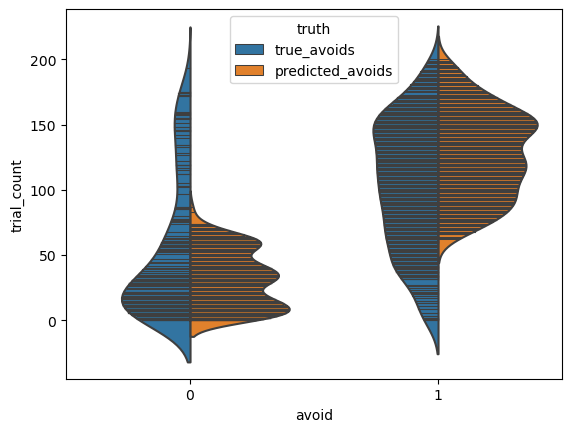

In [130]:
sns.violinplot(data = selected_data, 
              x = 'avoid', 
              y = 'trial_count',
              inner = 'stick',
              split = True,
              hue = 'truth',
              alpha = 0.5)

<Axes: xlabel='trial_count', ylabel='avoid'>

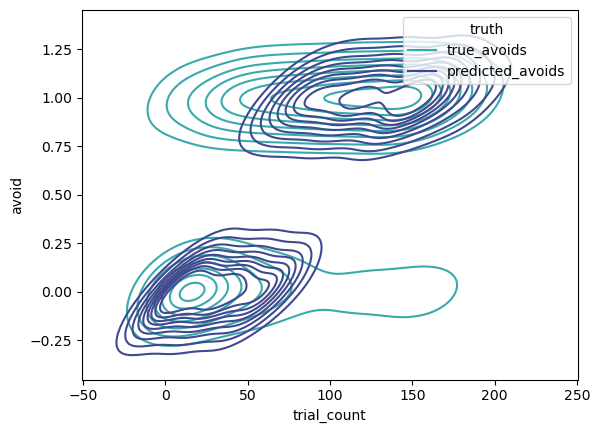

In [132]:
sns.kdeplot(data = selected_data, x = 'trial_count',
            y = 'avoid', 
            hue = 'truth',
            # fill = True,
            thresh = 0.1,
            # levels = 1000,
            palette = 'mako_r')


In [ ]:
classifer_processor = (TrainingProcessor(data)
                       .drop_colinear_columns('action_escape')
                       .query_sensor_and_sort_trials_by_subject(sensor = 'DA')
                       .split_train_val_test_by_subject(target = 'action_avoid')
                       .save_subjects_by_category(path = "/Users/mds8301/iterm_data_storage")

# build base model from base class

In [8]:

from src.models.BaseClassifier import BaseClassifier
model = BaseClassifier(
    number_of_layers=3, 
    number_of_units=10,
    dropout_rate=0.3)

metrics = [tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc-roc')]
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=metrics)
model.fit(classifer_processor.train_x, classifer_processor.train_y,
          epochs=300 , batch_size=100, 
          validation_data=(classifer_processor.val_x, classifer_processor.val_y))

Epoch 1/300
42/42 [==============================] - 2s 23ms/step - loss: 2.3166 - accuracy: 0.2851 - precision: 0.2414 - recall: 0.1169 - auc-roc: 0.2427 - val_loss: 1.4657 - val_accuracy: 0.3306 - val_precision: 0.4769 - val_recall: 0.3351 - val_auc-roc: 0.2822
Epoch 2/300
42/42 [==============================] - 0s 11ms/step - loss: 1.2487 - accuracy: 0.3412 - precision: 0.4148 - recall: 0.3706 - auc-roc: 0.2821 - val_loss: 0.8892 - val_accuracy: 0.5678 - val_precision: 0.6248 - val_recall: 0.8342 - val_auc-roc: 0.3367
Epoch 3/300
42/42 [==============================] - 0s 12ms/step - loss: 0.9253 - accuracy: 0.5052 - precision: 0.5453 - recall: 0.8113 - auc-roc: 0.3617 - val_loss: 0.8527 - val_accuracy: 0.6297 - val_precision: 0.6420 - val_recall: 0.9694 - val_auc-roc: 0.3943
Epoch 4/300
42/42 [==============================] - 0s 11ms/step - loss: 0.8995 - accuracy: 0.5426 - precision: 0.5606 - recall: 0.9261 - auc-roc: 0.4064 - val_loss: 0.8425 - val_accuracy: 0.6379 - val_preci

NameError: name 'plot_metrics' is not defined

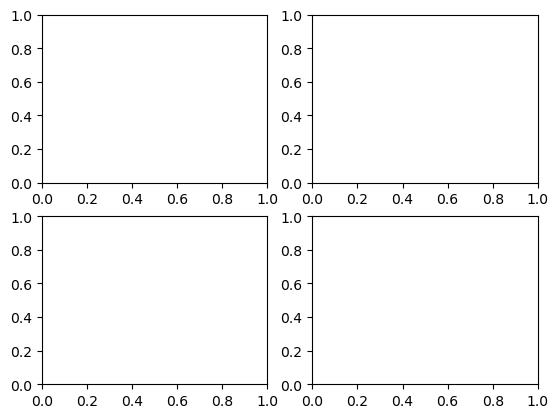

In [9]:
fig, ax = plt.subplots(2,2)
plot_metrics('loss', 'val_loss', model = model, title = 'Loss', ax = ax[0,0])
plot_metrics('accuracy', 'val_accuracy', model = model, title = 'Accuracy', ax = ax[0,1])
plot_metrics('precision', 'val_precision', model = model, title = 'Precision', ax = ax[1,0])
plot_metrics('auc-roc', 'val_auc-roc', model = model, title = 'Recall', ax = ax[1,1])
plt.tight_layout()

In [11]:
model.metrics_names
evaluation = model.evaluate(classifer_processor.test_x, classifer_processor.test_y, verbose=0)

In [12]:
evaluation

[0.7658211588859558,
 0.6451388597488403,
 0.591911792755127,
 0.9057665467262268,
 0.7505329847335815]

In [14]:
results ={}
for name, value in zip(model.metrics_names, evaluation):
    results[name] = value
results['model'] = model


In [15]:
results

{'loss': 0.7658211588859558,
 'accuracy': 0.6451388597488403,
 'precision': 0.591911792755127,
 'recall': 0.9057665467262268,
 'auc-roc': 0.7505329847335815,
 'model': <src.models.BaseClassifier.BaseClassifier at 0x29498fdd0>}